In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
from tqdm import tqdm 
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    

os.chdir(r'C:\Users\User\GitHub\WebET_Analysis')
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


# Cluster-corrected or the standard datset?

In [2]:
use_adjusted_et_data = False

# Read Data

In [3]:
if use_adjusted_et_data: 
    print('Using adjusted et data \n')
    data_et = pd.read_csv(
        r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/choice_task/adjusted/data_et.csv')
else: 
    data_et = pd.read_csv(
        r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/choice_task/cleaned/data_et.csv')
    
data_trial = pd.read_csv(
    r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/choice_task/cleaned/data_trial.csv')
data_subject = pd.read_csv(
    r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/choice_task/cleaned/data_subject.csv')    

et_trials = data_et.loc[:, ['run_id', 'trial_index']] \
    .drop_duplicates()

summary = pd.DataFrame(
   {'dataset': 
        [ 
           'data_et',
           'data_trial',
           'data_subject'
        ],
    'runs': 
        [
            len(data_et['run_id'].unique()),
            len(data_trial['run_id'].unique()),
            len(data_subject['run_id'].unique()),
        ],
    'n_trials': 
        [
            len(et_trials),
            len(data_trial['trial_index']),
            '-',
        ]
   }
) 
summary

,dataset,runs,n_trials
0,data_et,208,16502
1,data_trial,208,16596
2,data_subject,208,-


# Choice options

## Choice attributes

In [4]:
def identify_amount_left(data):
    data['amountLeft'] = 0 
    data.loc[
        (data['option_topLeft'].str.contains("\$", regex=True)) |
        (data['option_topLeft'].str.contains("cent", regex=True)), 
        'amountLeft'] = 1
    data['amountLeft'].unique()
    return data

data_trial = identify_amount_left(data_trial)
data_trial.loc[:, ['amountLeft', 'option_topLeft']].head()

,amountLeft,option_topLeft
0,0,7 days
1,0,Today
2,0,Today
3,0,Today
4,0,Today


In [5]:
def merge_by_index(data_et, source_data, varName):
    
    if varName in data_et.columns: 
        data_et=data_et.drop(columns=varName)
        
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    
    return data_et

data_et = merge_by_index(data_et, data_trial, 'amountLeft')
print(data_et['amountLeft'].unique())
data_et['amountLeft'].unique()

[0 1]


array([0, 1], dtype=int64)

In [6]:
def choice_options_to_numeric(data, varName): 
    data[varName + '_num'] = data[varName]
    data[varName + '_num'] = data[varName + '_num'] \
        .replace(['Today', 'Tomorrow', '7 days', 
                  '15 days', '30 days', '90 days', 
                  '180 days'], 
                 [0, 1, 7, 15, 30, 90, 180]) \
        .replace({'\$':''}, regex = True) \
        .replace('50 cent', 0.5) \
        .astype(float)
    return data

data_trial = data_trial \
    .rename(columns={
    'option_topLeft': 'option_TL', 
    'option_bottomLeft': 'option_BL', 
    'option_topRight': 'option_TR', 
    'option_bottomRight': 'option_BR'
    })

variables = [
    'option_TL',
    'option_BL', 
    'option_TR', 
    'option_BR'
]
for var in variables:
    data_trial = choice_options_to_numeric(data_trial, var) 
    
data_trial.loc[
    :, 
    [
    'option_TL',
    'option_BL', 
    'option_TR', 
    'option_BR',
    'option_TL_num',
    'option_BL_num', 
    'option_TR_num', 
    'option_BR_num'
    ]
]

,option_TL,option_BL,option_TR,option_BR,option_TL_num,option_BL_num,option_TR_num,option_BR_num
0,7 days,Today,$4,$2.5,7.0,0.0,4.0,2.5
1,Today,30 days,$4.5,$5,0.0,30.0,4.5,5.0
2,Today,15 days,$4.5,$5,0.0,15.0,4.5,5.0
3,Today,15 days,$3.5,$5,0.0,15.0,3.5,5.0
4,Today,90 days,$2.5,$5,0.0,90.0,2.5,5.0
...,...,...,...,...,...,...,...,...
16591,30 days,Today,$4,$3,30.0,0.0,4.0,3.0
16592,15 days,Today,$5,$3,15.0,0.0,5.0,3.0
16593,90 days,Today,$4,$2,90.0,0.0,4.0,2.0
16594,Today,15 days,$4,$4.5,0.0,15.0,4.0,4.5


In [7]:
def reformat_attributes(data):    
    data['aSS'] = 0 
    data.loc[data['amountLeft']==1, 'aSS']= \
        data.loc[
            data['amountLeft']==1, 
            ["option_TL_num", "option_BL_num"]
        ].values.min(1)
    data.loc[data['amountLeft']==0, 'aSS']= \
        data.loc[
            data['amountLeft']==0, 
            ["option_TR_num", "option_BR_num"]
        ].values.min(1)

    data['aLL'] = 0 
    data.loc[data['amountLeft']==1, 'aLL']= \
        data.loc[
            data['amountLeft']==1, 
            ["option_TL_num", "option_BL_num"]
        ].values.max(1)
    data.loc[data['amountLeft']==0, 'aLL']= \
        data.loc[
            data['amountLeft']==0, 
            ["option_TR_num", "option_BR_num"]
        ].values.max(1)
    
    data.loc[:, "tSS"] = 0 
    
    data['tLL'] = 0 
    data.loc[data['amountLeft']==1, 'tLL']= \
        data.loc[
            data['amountLeft']==1, 
            ["option_TR_num", "option_BR_num"]
        ].values.max(1)
    data.loc[data['amountLeft']==0, 'tLL']= \
        data.loc[
            data['amountLeft']==0, 
            ["option_TL_num", "option_BL_num"]
        ].values.max(1)
    
    data['LL_top'] = \
        (data["option_TL_num"] > data["option_BL_num"]) \
        .astype(int)

    print('aLL values: ' + str(np.sort(data['aLL'].unique())))
    print('aSS values: ' + str(np.sort(data['aSS'].unique())))
    print('tLL values: ' + str(np.sort(data['tLL'].unique())))
    print('tSS values: ' + str(np.sort(data['tSS'].unique())))
    
    return data

data_trial = reformat_attributes(data_trial)
data_trial.loc[
    : , 
    [
        'amountLeft', 
        'option_TL',
        'option_BL', 
        'option_TR', 
        'option_BR', 
        'aLL', 
        'aSS', 
        'tLL', 
        'tSS',
        'LL_top'
    ] 
]

aLL values: [4.  4.5 5. ]
aSS values: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]
tLL values: [  1.   7.  15.  30.  90. 180.]
tSS values: [0]


,amountLeft,option_TL,option_BL,option_TR,option_BR,aLL,aSS,tLL,tSS,LL_top
0,0,7 days,Today,$4,$2.5,4.0,2.5,7.0,0,1
1,0,Today,30 days,$4.5,$5,5.0,4.5,30.0,0,0
2,0,Today,15 days,$4.5,$5,5.0,4.5,15.0,0,0
3,0,Today,15 days,$3.5,$5,5.0,3.5,15.0,0,0
4,0,Today,90 days,$2.5,$5,5.0,2.5,90.0,0,0
...,...,...,...,...,...,...,...,...,...,...
16591,0,30 days,Today,$4,$3,4.0,3.0,30.0,0,1
16592,0,15 days,Today,$5,$3,5.0,3.0,15.0,0,1
16593,0,90 days,Today,$4,$2,4.0,2.0,90.0,0,1
16594,0,Today,15 days,$4,$4.5,4.5,4.0,15.0,0,0


In [8]:
def top_bottom_attributes(data):
    data['aT'] = data['LL_top'] * data['aLL'] + \
        (1-data['LL_top']) * data['aSS']
    data['aB'] = (1-data['LL_top']) * data['aLL'] + \
        data['LL_top'] * data['aSS']
    data['tT'] = data['LL_top'] * data['tLL'] + \
        (1-data['LL_top']) * data['tSS']
    data['tB'] = (1-data['LL_top']) * data['tLL'] + \
        data['LL_top'] * data['tSS']
    
    return(data)

data_trial = top_bottom_attributes(data_trial)
data_trial.loc[
    :, 
    ['aT', 'tT', 'aB', 'tB', 'LL_top']
].sort_values(by='LL_top')

,aT,tT,aB,tB,LL_top
8297,4.0,0.0,4.5,180.0,0
9185,3.5,0.0,5.0,180.0,0
9186,4.0,0.0,5.0,7.0,0
9187,2.5,0.0,4.0,15.0,0
9195,1.5,0.0,4.5,7.0,0
...,...,...,...,...,...
9749,4.5,180.0,2.5,0.0,1
9751,4.5,15.0,1.0,0.0,1
3393,4.5,90.0,2.0,0.0,1
3392,4.5,180.0,2.0,0.0,1


In [9]:
data_et = merge_by_index(
    data_et, 
    data_trial, 
    'LL_top'
)

## Behavioral response variables

In [10]:
def choice_response_variables(data):
    
    # Up-Arrow is 38, Down-Arrow is 40
    data["choseTop"] = 0
    data.loc[(data["key_press"]==38), "choseTop"] = 1

    data["choseLL"] = 0
    data.loc[(data["choseTop"]==1) & (data["LL_top"] == 1), "choseLL"] = 1
    data.loc[(data["choseTop"]==0) & (data["LL_top"] == 0), "choseLL"] = 1
    
    return(data)

data_trial = choice_response_variables(data_trial)

# Check these subjects:  19   32   66   96  126  130 1000 2012
data_trial.loc[
    :, # data_trial['run_id']==32, 
    [
        'amountLeft', 
        'option_TL',
        'option_TR', 
        'option_BL', 
        'option_BR', 
        'key_press',
        'choseTop',
        'choseLL', 
        ]
].sort_values(by='amountLeft')

,amountLeft,option_TL,option_TR,option_BL,option_BR,key_press,choseTop,choseLL
0,0,7 days,$4,Today,$2.5,38.0,1,1
9182,0,90 days,$4.5,Today,$3,38.0,1,1
9183,0,Today,$3.5,15 days,$4,40.0,0,1
9184,0,7 days,$5,Today,$4.5,40.0,0,0
9185,0,Today,$3.5,180 days,$5,40.0,0,1
...,...,...,...,...,...,...,...,...
9742,1,50 cent,Today,$4.5,30 days,40.0,0,1
9743,1,$5,7 days,$1.5,Today,38.0,1,1
9744,1,$4,Today,$5,15 days,38.0,1,0
9746,1,$2.5,Today,$4,7 days,40.0,0,1


In [11]:
data_trial.loc[
    (data_trial['choseTop']==1) &
    (data_trial['LL_top']==1)
    ,
    [
        'amountLeft', 
        'option_TL',
        'option_TR', 
        'option_BL', 
        'option_BR',
        'key_press',
        'choseLL'
    ]
].sort_values(by='amountLeft')

,amountLeft,option_TL,option_TR,option_BL,option_BR,key_press,choseLL
0,0,7 days,$4,Today,$2.5,38.0,1
9106,0,30 days,$4.5,Today,$1.5,38.0,1
9111,0,Tomorrow,$4,Today,$3.5,38.0,1
9113,0,15 days,$4.5,Today,$3,38.0,1
9118,0,Tomorrow,$5,Today,$4,38.0,1
...,...,...,...,...,...,...,...
9738,1,$5,15 days,$1.5,Today,38.0,1
9739,1,$4.5,15 days,$4,Today,38.0,1
9743,1,$5,7 days,$1.5,Today,38.0,1
9753,1,$5,30 days,$2,Today,38.0,1


## Aggregate on subject level

In [12]:
def merge_mean_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data
for var in ['choseLL', 'choseTop', 'LL_top']:
    data_subject = merge_mean_by_subject(data_subject, data_trial, var)
data_subject.loc[
    :,
    ['run_id', 'choseLL', 'choseTop', 'LL_top']
].head(5)

,run_id,choseLL,choseTop,LL_top
0,309,0.6125,0.4875,0.5000
1,327,0.5750,0.5625,0.6125
2,244,0.7375,0.5250,0.5375
3,358,0.1875,0.5250,0.4875
4,429,0.9000,0.5750,0.5750


# k

In [13]:
def k(aLL, aSS, tLL):
    k = ((aLL / aSS) - 1) / tLL
    return k

data_trial['k'] = k(data_trial['aLL'], data_trial['aSS'], data_trial['tLL']) 
data_trial

,run_id,chinFirst,task_nr,trial_index,trial_type,withinTaskIndex,choiceTask_amountLeftFirst,option_TL,option_BL,option_TR,...,tSS,tLL,LL_top,aT,aB,tT,tB,choseTop,choseLL,k
0,103,0,3.0,273,eyetracking-choice,2.0,0,7 days,Today,$4,...,0,7.0,1,4.0,2.5,7.0,0.0,1,1,0.085714
1,103,0,3.0,276,eyetracking-choice,3.0,0,Today,30 days,$4.5,...,0,30.0,0,4.5,5.0,0.0,30.0,0,1,0.003704
2,103,0,3.0,279,eyetracking-choice,4.0,0,Today,15 days,$4.5,...,0,15.0,0,4.5,5.0,0.0,15.0,0,1,0.007407
3,103,0,3.0,282,eyetracking-choice,5.0,0,Today,15 days,$3.5,...,0,15.0,0,3.5,5.0,0.0,15.0,0,1,0.028571
4,103,0,3.0,285,eyetracking-choice,6.0,0,Today,90 days,$2.5,...,0,90.0,0,2.5,5.0,0.0,90.0,0,1,0.011111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16591,96,1,2.0,371,eyetracking-choice,76.0,1,30 days,Today,$4,...,0,30.0,1,4.0,3.0,30.0,0.0,0,0,0.011111
16592,96,1,2.0,374,eyetracking-choice,77.0,1,15 days,Today,$5,...,0,15.0,1,5.0,3.0,15.0,0.0,1,1,0.044444
16593,96,1,2.0,377,eyetracking-choice,78.0,1,90 days,Today,$4,...,0,90.0,1,4.0,2.0,90.0,0.0,0,0,0.011111
16594,96,1,2.0,380,eyetracking-choice,79.0,1,Today,15 days,$4,...,0,15.0,0,4.0,4.5,0.0,15.0,1,0,0.008333


# Look direction

In [14]:
def lookDirections(data):
    data["look_left"] = (data["x"] < 0.5).astype(int)
    data["look_top"] = (data["y"] < 0.5).astype(int)
    return data

data_et = lookDirections(data_et)

# AOIs

AOI will be calculated. No cluster correction. 
[0 'TL' 'TR' 'BR' 'BL']
Unique AOIs: [0 'TL' 'TR' 'BR' 'BL']


(0.0, 1.0)

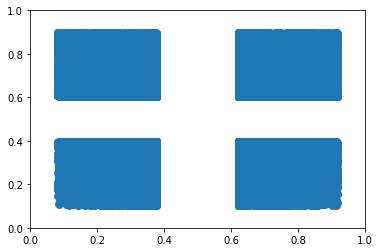

In [15]:
def add_aoi(data, aoi_width, aoi_height): 
    aoiCenters = pd.DataFrame(
        [
            [(0.05+0.9*0.2), 0.75],
            [(0.05+0.9*0.8), 0.75],
            [(0.05+0.9*0.2), 0.25],
            [(0.05+0.9*0.8), 0.25]
        ], 
        columns = ['x', 'y'],
        index = ['TL', 'TR', 'BL', 'BR']
    )
    
    data['aoi'] = 0 
    for aoi in aoiCenters.index:
        data.loc[
            (
                (data['x'] > (aoiCenters.loc[aoi, 'x'] - aoi_width/2)) & \
                (data['x'] < (aoiCenters.loc[aoi, 'x'] + aoi_width/2)) & \
                (data['y'] > (aoiCenters.loc[aoi, 'y'] - aoi_height/2)) & \
                (data['y'] < (aoiCenters.loc[aoi, 'y'] + aoi_height/2))
             ), 'aoi'] = aoi
    return data 

# If not already done in Matlab
if np.invert(use_adjusted_et_data):
    print('AOI will be calculated. No cluster correction. ')
    data_et = add_aoi(data_et, 0.3, 0.3)
    print(data_et['aoi'].unique())
    
data_et['aoi'] = data_et['aoi'].replace(
    [1, 2, 3, 4], 
    ['TL', 'TR', 'BL', 'BR']
)

print(f"""Unique AOIs: {data_et['aoi'].unique()}""")

data_plot = data_et.loc[data_et['aoi']!=0, ['x', 'y']]
x = data_plot['x']
y = data_plot['y']
plt.scatter(x, y)
plt.ylim(0, 1)
plt.xlim(0, 1)

In [16]:
def create_aoi_columns(data):
    data['aoi_aLL'] = 0
    data['aoi_tLL'] = 0 
    data['aoi_aSS'] = 0 
    data['aoi_tSS'] = 0
    
    # If amounts are on the left side
    ## If the gaze point is in the top option
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='TL')), 
             'aoi_aLL'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='TR')), 
             'aoi_tLL'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='BL')), 
             'aoi_aSS'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='BR')), 
             'aoi_tSS'] = 1
    
    ## If the gaze point is in the bottom option
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='TL')), 
             'aoi_aSS'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='TR')), 
             'aoi_tSS'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='BL')), 
             'aoi_aLL'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='BR')), 
             'aoi_tLL'] = 1
    
    # If amounts are on the right side
    ## If the gaze point is in the top option
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='TL')), 
             'aoi_tLL'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='TR')), 
             'aoi_aLL'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='BL')), 
             'aoi_tSS'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='BR')),
             'aoi_aSS'] = 1

    ## If the gaze point is in the bottom option
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='TL')), 
             'aoi_tSS'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='TR')), 
             'aoi_aSS'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='BL')), 
             'aoi_tLL'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='BR')), 
             'aoi_aLL'] = 1
    return data

data_et = create_aoi_columns(data_et)

# Fixations

In [17]:
def fix_counter(aoi_vector):
    aoi_numbers = aoi_vector \
        .replace(['TL', 'TR', 'BL', 'BR'], np.arange(1, 5)) \
        .astype(int) \
        .reset_index(drop=True)
    counter = 0

    fix_counter = np.zeros(len(aoi_numbers))
    fix_counter[0] = int(aoi_numbers[0] != 0)

    for i in np.delete(aoi_numbers.index, 0):
        if (
            (aoi_numbers[i] > 0) &  
            (aoi_numbers[i] != aoi_numbers[i-1])
           ):
            counter += 1

        if aoi_numbers[i] > 0:
            fix_counter[i] = counter 

    return fix_counter

In [18]:
def add_fixation_counter(data):
    data = data.copy()
    data.loc[:, 'fix_counter'] = 0
    
    for subject in tqdm(data['run_id'].unique()):
        for trial in data.loc[data['run_id']==subject, 'withinTaskIndex'].unique():
            
            temp_aoi = data.loc[
                (data['run_id']==subject) &
                (data['withinTaskIndex']==trial), 
                'aoi']
            
            data.loc[
                (data['run_id']==subject) &
                (data['withinTaskIndex']==trial), 
                'fix_counter'] = fix_counter(temp_aoi)

    return data

data_et = add_fixation_counter(data_et)
data_et.groupby(['run_id', 'aoi'])['fix_counter'].count().head(5)

100%|████████████████████████████████████████████████████████████████████████████████| 208/208 [03:45<00:00,  1.09s/it]


run_id  aoi
4.0     0      1560
        BL       15
        BR       60
        TL      402
        TR      139
Name: fix_counter, dtype: int64

## fixations on trial level

In [19]:
data_trial = data_trial \
    .merge(
        data_et.groupby(['run_id', 'withinTaskIndex'])['fix_counter'].nunique(),
        on=['run_id', 'withinTaskIndex'],
        how='left'
    ) \
    .rename(columns={'n_fixations': 'fix_counter'})

# Eye-Tracking indices

## Add AOI counts

       run_id  trial_index  aoi_aSS  aoi_aLL  aoi_tSS  aoi_tLL
0         4.0        270.0        0        6        0        1
1         4.0        273.0        8        0        2        1
2         4.0        276.0        6        0        2        0
3         4.0        279.0        1        0        2        5
4         4.0        282.0        0        0        2        0
...       ...          ...      ...      ...      ...      ...
16497   462.0        380.0        3        0        0        0
16498   462.0        383.0        0        3        0        0
16499   462.0        386.0        0        3        5        0
16500   462.0        389.0        3        0        2        1
16501   462.0        392.0        1        0       14        0

[16502 rows x 6 columns]


<ipython-input-20-70060fc108e5>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data_et.groupby(['run_id', 'trial_index']) \


(array([5.8033e+04, 5.7380e+03, 1.3800e+03, 4.5200e+02, 1.9300e+02,
        1.0800e+02, 3.7000e+01, 3.7000e+01, 1.0000e+01, 5.0000e+00,
        3.0000e+00, 3.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,   8.1,  16.2,  24.3,  32.4,  40.5,  48.6,  56.7,  64.8,
         72.9,  81. ,  89.1,  97.2, 105.3, 113.4, 121.5, 129.6, 137.7,
        145.8, 153.9, 162. ]),
 <BarContainer object of 20 artists>)

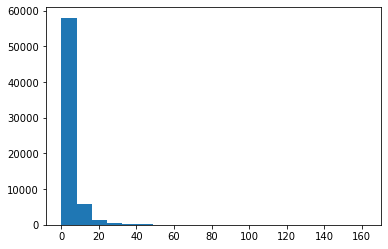

In [20]:
grouped = data_et.groupby(['run_id', 'trial_index']) \
        ['aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL'].sum() \
        .reset_index() 
print(grouped)

data_plot = pd.DataFrame(pd.concat(
    [
        grouped['aoi_aSS'],
        grouped['aoi_tSS'],
        grouped['aoi_aLL'],
        grouped['aoi_tLL']
    ]), columns=['n']) 

plt.hist(data_plot, bins=20)

In [21]:
for var in ['aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL']:
    if var in data_trial.columns: 
        data_trial = data_trial.drop(columns=[var])
        
data_trial = data_trial.merge(
    grouped, 
    on=['run_id', 'trial_index'], 
    how='left')
    
data_trial.loc[
    :, 
    ['run_id', 'trial_index', 'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL']
]

,run_id,trial_index,aoi_aSS,aoi_aLL,aoi_tSS,aoi_tLL
0,103,273,16.0,13.0,5.0,11.0
1,103,276,13.0,24.0,8.0,28.0
2,103,279,15.0,29.0,13.0,12.0
3,103,282,11.0,11.0,7.0,15.0
4,103,285,15.0,2.0,8.0,7.0
...,...,...,...,...,...,...
16591,96,371,10.0,10.0,0.0,8.0
16592,96,374,12.0,16.0,0.0,7.0
16593,96,377,3.0,7.0,0.0,0.0
16594,96,380,18.0,7.0,2.0,13.0


##  Option Index

In [22]:
def require_min_gaze_points(data, min_required_count):
    return data.replace(
        np.arange(min_required_count), 
        np.repeat(0, min_required_count)) 

def addOptionIndex(data):
    
    gazePoints_immediate = \
        require_min_gaze_points(data['aoi_aSS'], 3) + \
        require_min_gaze_points(data['aoi_tSS'], 3)
    gazePoints_delay = \
        require_min_gaze_points(data['aoi_aLL'], 3) + \
        require_min_gaze_points(data['aoi_tLL'], 3)
    optionIndex = \
        (gazePoints_immediate - gazePoints_delay) / \
        (gazePoints_immediate + gazePoints_delay)
    
    return optionIndex

data_trial['optionIndex'] = addOptionIndex(data_trial)
print(data_trial['optionIndex'].describe())
print(
    pd.DataFrame(
        [
            [sum(pd.isna(data_trial['optionIndex']))],
            [sum(data_trial['optionIndex']==1)],
            [sum(data_trial['optionIndex']==0)],
            [sum((data_trial['optionIndex']>0) &
                 (data_trial['optionIndex']<1))],
            [len(data_trial)]
        ], index = ['NAN', '1', '0', '0>optionIndex>1', 'total']    
    )
)

print(data_trial.loc[
    :, 
    [
        'run_id', 'trial_index', 
        'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL', 
        'optionIndex'
    ]
].head(5))

count    13112.000000
mean        -0.052581
std          0.859524
min         -1.000000
25%         -1.000000
50%         -0.125000
75%          1.000000
max          1.000000
Name: optionIndex, dtype: float64
                     0
NAN               3484
1                 4264
0                  234
0>optionIndex>1   1764
total            16596
   run_id  trial_index  aoi_aSS  aoi_aLL  aoi_tSS  aoi_tLL  optionIndex
0     103          273     16.0     13.0      5.0     11.0    -0.066667
1     103          276     13.0     24.0      8.0     28.0    -0.424658
2     103          279     15.0     29.0     13.0     12.0    -0.188406
3     103          282     11.0     11.0      7.0     15.0    -0.181818
4     103          285     15.0      2.0      8.0      7.0     0.533333


## Attribute Index

In [23]:
def addAttributeIndex(data):

    gazePoints_amount = \
        require_min_gaze_points(data['aoi_aLL'], 3) + \
        require_min_gaze_points(data['aoi_aSS'], 3)
    gazePoints_time = \
        require_min_gaze_points(data['aoi_tLL'], 3) + \
        require_min_gaze_points(data['aoi_tSS'], 3)

    attributeIndex = \
        (gazePoints_amount - gazePoints_time) / \
        (gazePoints_amount + gazePoints_time)
    
    return attributeIndex


data_trial['attributeIndex'] = addAttributeIndex(data_trial)

print(data_trial['attributeIndex'].describe())
print(pd.DataFrame(
        [
            [sum(pd.isna(data_trial['attributeIndex']))],
            [sum(data_trial['attributeIndex']==1)],
            [sum(data_trial['attributeIndex']==0)],
            [sum((data_trial['attributeIndex']>0) &
                 (data_trial['attributeIndex']<1))],
            [len(data_trial)]
        ], index = ['NAN', '1', '0', '0>attributeIndex>1', 'total']    
    )
)

print(data_trial.loc[
    :, 
    [
        'run_id', 'trial_index', 
        'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL', 
        'attributeIndex'
    ]
].head(5))

count    13112.000000
mean         0.204111
std          0.768606
min         -1.000000
25%         -0.400000
50%          0.280000
75%          1.000000
max          1.000000
Name: attributeIndex, dtype: float64
                        0
NAN                  3484
1                    4989
0                     361
0>attributeIndex>1   2932
total               16596
   run_id  trial_index  aoi_aSS  aoi_aLL  aoi_tSS  aoi_tLL  attributeIndex
0     103          273     16.0     13.0      5.0     11.0        0.288889
1     103          276     13.0     24.0      8.0     28.0        0.013699
2     103          279     15.0     29.0     13.0     12.0        0.275362
3     103          282     11.0     11.0      7.0     15.0        0.000000
4     103          285     15.0      2.0      8.0      7.0        0.000000


## Payne Index

### Transitions between AOIs

In [24]:
def et_data_transition_type(data):
    data = data.loc[
        pd.notna(data['aoi']) &
        (data['aoi']!=0), :]
    data['newAOIIndex'] = 0
    data.loc[(data['aoi_aLL']==1), 'newAOIIndex'] = 1
    data.loc[(data['aoi_tLL']==1), 'newAOIIndex'] = 2
    data.loc[(data['aoi_aSS']==1), 'newAOIIndex'] = 4
    data.loc[(data['aoi_tSS']==1), 'newAOIIndex'] = 8
    data.sort_values(by=['run_id', 'withinTaskIndex'])
    # Add a 0 due to the way np.diff works
    data['transition_type'] = np.append([0], np.diff(data['newAOIIndex']))
    data['transition_type'] = abs(data['transition_type']) 

    data.loc[data['t_task']==0, 'transition_type'] = 0

    return data.loc[:, ['run_id', 'trial_index', 't_task', 'transition_type']]

def addTransition_type(data, data_et):
    data_et = et_data_transition_type(data_et)
    data_et.loc[:, 'transition_type'] = data_et.loc[:, 'transition_type']
    
    transition_count = pd.pivot_table(
        data_et.loc[:, ['run_id', 'trial_index', 'transition_type']], 
        index = ['run_id', 'trial_index'],
        columns = ['transition_type'], 
        aggfunc = len,
        fill_value = 0) \
        .reset_index() \
        .rename(columns={
        0: "trans_type_0",
        1: "trans_type_aLLtLL",
        2: "trans_type_tLLaSS",
        3: "trans_type_aLLaSS",
        4: "trans_type_aSStSS",
        6: "trans_type_tLLtSS",
        7: "trans_type_aLLtSS", 
        8: "trans_type_0_tSS",
    })
    
    transition_columns = ["trans_type_0", "trans_type_aLLtLL", 
            "trans_type_tLLaSS", "trans_type_aLLaSS",
            "trans_type_aSStSS", "trans_type_tLLtSS", 
            "trans_type_aLLtSS"]
    
    for var in transition_columns:
        if var in data: 
            data = data.drop(columns=[var])
        
    data = data.merge(transition_count, on=['run_id', 'trial_index'], how='left') 
    data.loc[:, transition_columns] = data.loc[:, transition_columns] \
        .fillna(0)
    return(data)

data_trial = addTransition_type(data_trial, data_et)
data_trial.loc[
    :, 
    [
        'run_id', 'trial_index',
        'aoi_aLL', 'aoi_aSS', 'aoi_tLL', 'aoi_tSS',
        'trans_type_0', 'trans_type_aLLtLL', 'trans_type_tLLaSS',
        'trans_type_aLLaSS', 'trans_type_aSStSS', 'trans_type_tLLtSS',
        'trans_type_aLLtSS'
    ]
].head(5)

<ipython-input-24-06dfb2d27eb4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['newAOIIndex'] = 0
C:\Users\User\miniconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\User\miniconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,run_id,trial_index,aoi_aLL,aoi_aSS,aoi_tLL,aoi_tSS,trans_type_0,trans_type_aLLtLL,trans_type_tLLaSS,trans_type_aLLaSS,trans_type_aSStSS,trans_type_tLLtSS,trans_type_aLLtSS
0,103,273,13.0,16.0,11.0,5.0,34.0,4.0,2.0,3.0,1.0,1.0,0.0
1,103,276,24.0,13.0,28.0,8.0,59.0,6.0,2.0,2.0,2.0,1.0,1.0
2,103,279,29.0,15.0,12.0,13.0,55.0,5.0,1.0,3.0,4.0,1.0,0.0
3,103,282,11.0,11.0,15.0,7.0,37.0,1.0,2.0,1.0,2.0,1.0,0.0
4,103,285,2.0,15.0,7.0,8.0,26.0,2.0,0.0,2.0,2.0,0.0,0.0


In [25]:
def addPayneIndex(data):
    
    optionWise_transition = \
        data['trans_type_aLLtLL'] + \
        data['trans_type_aSStSS']
    attributeWise_transition = \
        data['trans_type_aLLaSS'] + \
        data['trans_type_tLLtSS']  
        
    payneIndex = \
        (optionWise_transition - attributeWise_transition) / \
        (optionWise_transition + attributeWise_transition) 
    

    return payneIndex

data_trial['payneIndex'] = addPayneIndex(data_trial)

print(data_trial['payneIndex'].describe())
print(pd.DataFrame(
        [
            [sum(pd.isna(data_trial['payneIndex']))],
            [sum(data_trial['payneIndex']==1)],
            [sum(data_trial['payneIndex']==0)],
            [sum((data_trial['payneIndex']>0) &
                 (data_trial['payneIndex']<1))],
            [len(data_trial)]
        ], index = ['NAN', '1', '0', '0>payneIndex>1', 'total']    
    )
)

data_trial.loc[
    data_trial['fps']>15, 
    ['run_id', 'trial_duration_exact',
     'trans_type_aLLtLL', 'trans_type_aSStSS', 'trans_type_aLLaSS', 'trans_type_tLLtSS',
     'payneIndex'
    ]
].head(5)

count    11012.000000
mean         0.086829
std          0.806352
min         -1.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: payneIndex, dtype: float64
                    0
NAN              5584
1                3739
0                1752
0>payneIndex>1   1652
total           16596


,run_id,trial_duration_exact,trans_type_aLLtLL,trans_type_aSStSS,trans_type_aLLaSS,trans_type_tLLtSS,payneIndex
0,103,4929,4.0,1.0,3.0,1.0,0.111111
1,103,7106,6.0,2.0,2.0,1.0,0.454545
2,103,6489,5.0,4.0,3.0,1.0,0.384615
3,103,3878,1.0,2.0,1.0,1.0,0.200000
4,103,2967,2.0,2.0,2.0,0.0,0.333333


## Aggregate on subject-level

In [26]:
data_subject = merge_mean_by_subject(data_subject, data_trial, 'attributeIndex')
data_subject = merge_mean_by_subject(data_subject, data_trial, 'optionIndex')
data_subject = merge_mean_by_subject(data_subject, data_trial, 'payneIndex')

# k-value
http://alexanderfengler.github.io/neuroeconomics/K-Estimation/

According to Chabris and Laibson (2008), 'An agent chooses aLL, if Y / (1 + k*t) - X >= 0  holds true'

 - Index: Order: A column that stores the order of questions asked
 - aSS: SIR: Column storing the small immediate rewards by choice set
 - aLL: LDR: Column storing the large delayed rewards by choice set
 - tLL: Delay: Column storing the respecitve delays for LDR’s

In [27]:
data_k = data_trial.loc[
    data_trial['run_id']==11, 
    ['run_id', 'withinTaskIndex', 'aSS', 'aLL', 'tLL']]


# Reaction time on subject-level

In [28]:
grouped = data_trial.groupby(['run_id'])['trial_duration_exact'].mean() \
    .reset_index() \
    .rename(columns={'trial_duration_exact': 'choice_rt'})

if 'choice_rt' in data_subject.columns: data_subject = data_subject.drop(columns=['choice_rt'])
data_subject = data_subject.merge(grouped, on='run_id', how='left')
data_subject['choice_rt'].describe()

count     208.000000
mean     2074.435805
std       699.003487
min       567.400000
25%      1622.150000
50%      1987.531250
75%      2423.215625
max      4727.139241
Name: choice_rt, dtype: float64

# Clusters

In [29]:
data_cluster = data_trial.dropna(
    subset=['trans_type_0',
       'trans_type_aLLtLL', 'trans_type_tLLaSS', 'trans_type_aLLaSS',
       'trans_type_aSStSS', 'trans_type_tLLtSS'] , how='all')

data_cluster.loc[:, [
       'trans_type_0',
       'trans_type_aLLtLL', 'trans_type_tLLaSS', 'trans_type_aLLaSS',
       'trans_type_aSStSS', 'trans_type_tLLtSS']
                     ].isnull().any()

trans_type_0         False
trans_type_aLLtLL    False
trans_type_tLLaSS    False
trans_type_aLLaSS    False
trans_type_aSStSS    False
trans_type_tLLtSS    False
dtype: bool

In [30]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_cluster.loc[
    :, 
    ['trans_type_0',
     'trans_type_aLLtLL', 'trans_type_tLLaSS', 'trans_type_aLLaSS',
     'trans_type_aSStSS', 'trans_type_tLLtSS']
]
                                      )

In [31]:
def clusters(n_clusters):
    kmeans = KMeans(
        init="random",
        n_clusters=n_clusters,
        n_init=10,
        max_iter=300,
        random_state=42
    )
    kmeans.fit(scaled_features)
            
#     https://realpython.com/k-means-clustering-python/
#     print(kmeans.inertia_)
#     print(kmeans.cluster_centers_)
#     print(kmeans.n_iter_)

    return kmeans.labels_

In [32]:
output = []
X = data_cluster[["run_id"]] #, "withinTaskIndex"]]
X_ = sm.add_constant(X)
y = 1-data_cluster[["choseLL"]]  
log_reg = sm.Logit(y, X_).fit() 
output.append([0, log_reg.bic, log_reg.aic])
                  
for n_cluster in range(2, 5):
    data_cluster['cluster' + str(n_cluster)] = clusters(n_cluster)
    X = data_cluster[["run_id", 'cluster' + str(n_cluster)]]
    X_ = sm.add_constant(X)
    y = 1-data_cluster[["choseLL"]]  
    log_reg = sm.Logit(y, X_).fit() 
    output.append([n_cluster, log_reg.bic, log_reg.aic]) 

output = pd.DataFrame(output, columns = ['n_clusters', 'BIC', 'AIC']) \
    .set_index('n_clusters')
output

Optimization terminated successfully.
         Current function value: 0.595663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595520
         Iterations 5


,BIC,AIC
n_clusters,,
0,19790.696269,19775.262435
2,19613.906318,19590.755567
3,19780.740304,19757.589554
4,19795.661813,19772.511062


# Export data

In [33]:
if use_adjusted_et_data: 
    data_et.to_csv(
        "data_jupyter/choice_task/adjusted/data_et.csv", 
        index=False, header=True)
    data_trial.to_csv(
        "data_jupyter/choice_task/adjusted/data_trial.csv", 
        index=False, header=True)
    data_subject.to_csv(
        "data_jupyter/choice_task/adjusted/data_subject.csv", 
        index=False, header=True)
else:
    if not os.path.exists('./data_jupyter/choice_task/uncorrected'):
        os.mkdir('./data_jupyter/choice_task/uncorrected')
    
    data_et.to_csv(
        "data_jupyter/choice_task/uncorrected/data_et.csv", 
        index=False, header=True)
    data_trial.to_csv(
        "data_jupyter/choice_task/uncorrected/data_trial.csv", 
        index=False, header=True)
    data_subject.to_csv(
        "data_jupyter/choice_task/uncorrected/data_subject.csv", 
        index=False, header=True)

# Check datasets

In [35]:
et_trial_count = data_et.groupby(['run_id', 'trial_index'], as_index=False)['x'].count() \
    .loc[:, 'trial_index'].count()

summary = pd.DataFrame(
   {'dataset': 
        [ 
           'data_et',
           'data_trial',
           'data_subject'
        ],
    'runs': 
        [
            len(data_et['run_id'].unique()),
            len(data_trial['run_id'].unique()),
            len(data_subject['run_id'].unique()),
        ],
    'n_trials': 
        [
            et_trial_count,
            len(data_trial),
            '-'
        ]
   }
) 
summary

,dataset,runs,n_trials
0,data_et,208,16502
1,data_trial,208,16596
2,data_subject,208,-


# Feedback

In [ ]:
print('Success! Script ran through')